# From Word Vectors to Sequence Labeling

이 노트북은 텍스트가 토큰화되어 단어 임베딩을 거쳐 sequence labeling 모델로 들어가는 전체 파이프라인을 보여줍니다.

## 파이프라인 개요
1. **Tokenization**: 텍스트 → 토큰 시퀀스
2. **Token ID Conversion**: 토큰 → 토큰 ID
3. **One-hot Encoding**: 토큰 ID → One-hot 벡터
4. **Embedding**: One-hot 벡터 → Word Embedding 벡터 (Random vs Pre-trained)
5. **Sequence Labeling**: Sliding window MLP로 각 위치의 레이블 예측 (NER-style)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## 1. 예제 데이터 준비

Named Entity Recognition처럼 sequence labeling 태스크를 수행합니다.
여기서는 'LOCATION' 관련 단어들에 레이블을 부여합니다.

In [2]:
# 예제 문장들과 레이블 (BIO tagging)
# B-LOC: Begin Location, I-LOC: Inside Location, O: Outside
sentences_with_labels = [
    ("I visited Paris last summer", ["O", "O", "B-LOC", "O", "O"]),
    ("New York is a beautiful city", ["B-LOC", "I-LOC", "O", "O", "O", "O"]),
    ("She lives in Seoul", ["O", "O", "O", "B-LOC"]),
    ("Tokyo and London are great places", ["B-LOC", "O", "B-LOC", "O", "O", "O"]),
    ("I love Berlin in the spring", ["O", "O", "B-LOC", "O", "O", "O"]),
    ("San Francisco has amazing weather", ["B-LOC", "I-LOC", "O", "O", "O"]),
    ("Rome is the capital of Italy", ["B-LOC", "O", "O", "O", "O", "B-LOC"]),
    ("He moved to Sydney last year", ["O", "O", "O", "B-LOC", "O", "O"]),
    ("The weather is nice today", ["O", "O", "O", "O", "O"]),
    ("She enjoys reading books", ["O", "O", "O", "O"]),
    ("We had dinner yesterday", ["O", "O", "O", "O"]),
    ("The cat is sleeping", ["O", "O", "O", "O"]),
    ("I like coffee in the morning", ["O", "O", "O", "O", "O", "O"]),
    ("Barcelona is in Spain", ["B-LOC", "O", "O", "B-LOC"]),
    ("They traveled to Mumbai and Delhi", ["O", "O", "O", "B-LOC", "O", "B-LOC"]),
]

print(f"Total sentences: {len(sentences_with_labels)}")
print("\nExample sentences with labels:")
for i, (sent, labels) in enumerate(sentences_with_labels[:3]):
    words = sent.split()
    print(f"\n{i+1}. {sent}")
    for word, label in zip(words, labels):
        print(f"   {word:15s} -> {label}")

Total sentences: 15

Example sentences with labels:

1. I visited Paris last summer
   I               -> O
   visited         -> O
   Paris           -> B-LOC
   last            -> O
   summer          -> O

2. New York is a beautiful city
   New             -> B-LOC
   York            -> I-LOC
   is              -> O
   a               -> O
   beautiful       -> O
   city            -> O

3. She lives in Seoul
   She             -> O
   lives           -> O
   in              -> O
   Seoul           -> B-LOC


## 2. 간단한 Tokenizer 구축

Word-level tokenization을 사용하여 vocabulary를 만듭니다.

In [3]:
class SimpleTokenizer:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.vocab_size = 2
    
    def fit(self, sentences):
        """Build vocabulary from sentences"""
        for sent, _ in sentences:
            for word in sent.lower().split():
                if word not in self.word2idx:
                    self.word2idx[word] = self.vocab_size
                    self.idx2word[self.vocab_size] = word
                    self.vocab_size += 1
    
    def encode(self, sentence):
        """Convert sentence to token IDs"""
        return [self.word2idx.get(word.lower(), 1) for word in sentence.split()]
    
    def decode(self, token_ids):
        """Convert token IDs to words"""
        return [self.idx2word.get(idx, "<UNK>") for idx in token_ids]

# Build tokenizer
tokenizer = SimpleTokenizer()
tokenizer.fit(sentences_with_labels)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"\nFirst 20 words in vocabulary:")
for i in range(min(20, tokenizer.vocab_size)):
    print(f"  {i:3d}: {tokenizer.idx2word[i]}")

# Demo tokenization
example_text = "I visited Paris last summer"
token_ids = tokenizer.encode(example_text)
print(f"\nExample tokenization:")
print(f"  Text: {example_text}")
print(f"  Token IDs: {token_ids}")
print(f"  Decoded: {' '.join(tokenizer.decode(token_ids))}")

Vocabulary size: 61

First 20 words in vocabulary:
    0: <PAD>
    1: <UNK>
    2: i
    3: visited
    4: paris
    5: last
    6: summer
    7: new
    8: york
    9: is
   10: a
   11: beautiful
   12: city
   13: she
   14: lives
   15: in
   16: seoul
   17: tokyo
   18: and
   19: london

Example tokenization:
  Text: I visited Paris last summer
  Token IDs: [2, 3, 4, 5, 6]
  Decoded: i visited paris last summer


## 3. Label Encoding

BIO tags를 정수 인덱스로 변환합니다.

In [4]:
# Build label vocabulary
label2idx = {"O": 0, "B-LOC": 1, "I-LOC": 2}
idx2label = {0: "O", 1: "B-LOC", 2: "I-LOC"}
num_labels = len(label2idx)

print(f"Label vocabulary:")
for label, idx in label2idx.items():
    print(f"  {label:10s} -> {idx}")

Label vocabulary:
  O          -> 0
  B-LOC      -> 1
  I-LOC      -> 2


## 4. One-hot Encoding 시연

토큰 ID를 one-hot 벡터로 변환하는 과정을 보여줍니다.

In [5]:
def to_one_hot(token_id: int, vocab_size: int) -> np.ndarray:
    """토큰 ID를 one-hot 벡터로 변환"""
    one_hot = np.zeros(vocab_size)
    one_hot[token_id] = 1
    return one_hot

# Example
word = "paris"
token_id = tokenizer.word2idx[word]
one_hot = to_one_hot(token_id, tokenizer.vocab_size)

print(f"One-hot encoding for '{word}':")
print(f"  Token ID: {token_id}")
print(f"  Vector shape: {one_hot.shape}")
print(f"  Non-zero index: {np.argmax(one_hot)}")
print(f"  Vector (first 10 elements): {one_hot[:10]}")

One-hot encoding for 'paris':
  Token ID: 4
  Vector shape: (61,)
  Non-zero index: 4
  Vector (first 10 elements): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 5. Word Embeddings 준비

### 5.1 Random Initialization

In [6]:
embedding_dim = 50

# Random embedding matrix
random_embedding_matrix = np.random.randn(tokenizer.vocab_size, embedding_dim) * 0.1

print(f"Random embedding matrix shape: {random_embedding_matrix.shape}")
print(f"  ({tokenizer.vocab_size} words × {embedding_dim} dimensions)")

# Demonstrate matrix multiplication
word = "paris"
token_id = tokenizer.word2idx[word]
one_hot = to_one_hot(token_id, tokenizer.vocab_size)
word_embedding = one_hot @ random_embedding_matrix

print(f"\nWord embedding for '{word}' (random init):")
print(f"  One-hot shape: {one_hot.shape}")
print(f"  @ Embedding matrix shape: {random_embedding_matrix.shape}")
print(f"  = Word embedding shape: {word_embedding.shape}")
print(f"  First 10 dims: {word_embedding[:10]}")

Random embedding matrix shape: (61, 50)
  (61 words × 50 dimensions)

Word embedding for 'paris' (random init):
  One-hot shape: (61,)
  @ Embedding matrix shape: (61, 50)
  = Word embedding shape: (50,)
  First 10 dims: [ 0.06741725  0.11529395 -0.02164369  0.15865221 -0.04408391 -0.14165584
  0.14498618  0.03704705 -0.09618597 -0.09657053]


### 5.2 Pre-trained Word Embeddings

**세 가지 옵션을 제공합니다:**

1. **Gensim Word2Vec** (가장 빠름, 권장) - 자동 다운로드
2. **직접 Skip-gram 학습** (교육용, 매우 빠름)
3. **GloVe 다운로드** (느림, 822MB 다운로드)

아래 코드에서 `method` 변수를 바꿔서 선택하세요!

In [7]:
# ========== 여기서 방법 선택 ==========
method = "gensim"  # "gensim" (빠름, 권장) or "glove" (느림)
# ======================================

import os
import urllib.request
import zipfile

def load_gensim_embeddings(tokenizer, embedding_dim=50):
    """Gensim의 pre-trained embeddings 다운로드 (빠름, 약 66MB)"""
    print(f"Loading pre-trained embeddings via Gensim (dim={embedding_dim})...")
    
    # NumPy 호환성 이슈 회피
    import warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    try:
        import gensim.downloader as api
        
        # Load pre-trained model (자동 다운로드, 캐시됨)
        if embedding_dim == 50:
            model_name = "glove-wiki-gigaword-50"  # 약 66MB
        elif embedding_dim == 100:
            model_name = "glove-wiki-gigaword-100"
        elif embedding_dim == 200:
            model_name = "glove-wiki-gigaword-200"
        else:
            model_name = "glove-wiki-gigaword-50"
        
        print(f"Downloading {model_name} (happens only once, cached after that)...")
        wv = api.load(model_name)
        print(f"✓ Loaded {len(wv)} pre-trained word vectors")
        
        # Initialize embedding matrix
        embedding_matrix = np.random.randn(tokenizer.vocab_size, embedding_dim) * 0.1
        
        found = 0
        for word, idx in tokenizer.word2idx.items():
            if word in wv:
                embedding_matrix[idx] = wv[word]
                found += 1
        
        print(f"✓ Found {found}/{tokenizer.vocab_size} words in pre-trained embeddings")
        
        # Return dict for visualization
        glove_dict = {word: wv[word] for word in wv.index_to_key[:1000]}  # First 1000 words
        
        return embedding_matrix, glove_dict
        
    except Exception as e:
        print(f"⚠️  Gensim error: {e}")
        print("Falling back to GloVe download method...")
        return load_glove_embeddings(tokenizer, embedding_dim)


def load_glove_embeddings(tokenizer, embedding_dim=50):
    """GloVe 직접 다운로드 (느림, 822MB)"""
    glove_dir = "glove_data"
    os.makedirs(glove_dir, exist_ok=True)
    
    glove_file = f"{glove_dir}/glove.6B.{embedding_dim}d.txt"
    
    if not os.path.exists(glove_file):
        print("Downloading GloVe embeddings (822MB, this may take a while)...")
        url = "http://nlp.stanford.edu/data/glove.6B.zip"
        zip_path = f"{glove_dir}/glove.6B.zip"
        
        print("Downloading...")
        urllib.request.urlretrieve(url, zip_path)
        
        print("Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(glove_dir)
        
        os.remove(zip_path)
        print("✓ Done!")
    else:
        print(f"✓ GloVe file already exists: {glove_file}")
    
    print(f"Loading GloVe embeddings from {glove_file}...")
    
    # Load pre-trained embeddings
    glove_embeddings = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    
    print(f"✓ Loaded {len(glove_embeddings)} word vectors")
    
    # Initialize embedding matrix
    embedding_matrix = np.random.randn(tokenizer.vocab_size, embedding_dim) * 0.1
    
    found = 0
    for word, idx in tokenizer.word2idx.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
            found += 1
    
    print(f"✓ Found {found}/{tokenizer.vocab_size} words in GloVe")
    
    return embedding_matrix, glove_embeddings


# Load embeddings based on selected method
if method == "gensim":
    print("=" * 80)
    print("Method: Gensim auto-download (recommended, ~66MB)")
    print("=" * 80)
    pretrained_embedding_matrix, glove_dict = load_gensim_embeddings(tokenizer, embedding_dim)
    
elif method == "glove":
    print("=" * 80)
    print("Method: Direct GloVe download (slow, 822MB)")
    print("=" * 80)
    pretrained_embedding_matrix, glove_dict = load_glove_embeddings(tokenizer, embedding_dim)
    
else:
    raise ValueError(f"Unknown method: {method}. Choose 'gensim' or 'glove'")

Method: Gensim auto-download (recommended, ~66MB)
Loading pre-trained embeddings via Gensim (dim=50)...
[==================================================] 100.0% 66.0/66.0MB downloaded
✓ Loaded 400000 pre-trained word vectors
✓ Found 59/61 words in pre-trained embeddings


### 5.3 Word Embedding Visualization

t-SNE를 사용하여 pre-trained embeddings을 2D로 시각화합니다.

Applying t-SNE...


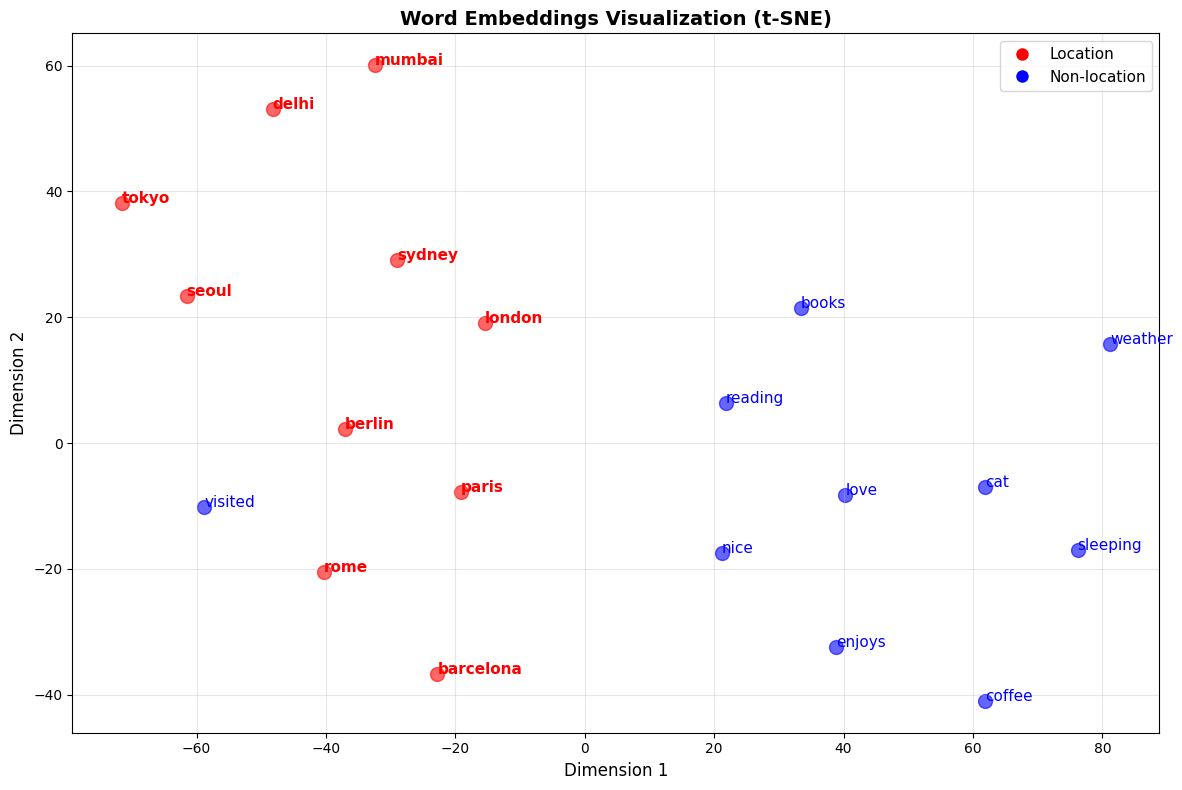


Note: Location words (red) tend to cluster together in the embedding space!


In [8]:
# 시각화할 단어들 선택 (location 단어들과 일반 단어들)
words_to_visualize = [
    # Location words
    'paris', 'london', 'tokyo', 'seoul', 'berlin', 'rome', 'sydney', 'barcelona', 'mumbai', 'delhi',
    # Non-location words
    'visited', 'weather', 'nice', 'love', 'enjoys', 'reading', 'books', 'coffee', 'cat', 'sleeping'
]

# Get embeddings for these words
word_indices = [tokenizer.word2idx.get(w, 1) for w in words_to_visualize]
embeddings_to_plot = pretrained_embedding_matrix[word_indices]

# Apply t-SNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(words_to_visualize)-1))
embeddings_2d = tsne.fit_transform(embeddings_to_plot)

# Plot
plt.figure(figsize=(12, 8))

# Separate location and non-location words
location_words = ['paris', 'london', 'tokyo', 'seoul', 'berlin', 'rome', 'sydney', 'barcelona', 'mumbai', 'delhi']

for i, word in enumerate(words_to_visualize):
    x, y = embeddings_2d[i]
    if word in location_words:
        plt.scatter(x, y, color='red', s=100, alpha=0.6)
        plt.annotate(word, (x, y), fontsize=11, fontweight='bold', color='red')
    else:
        plt.scatter(x, y, color='blue', s=100, alpha=0.6)
        plt.annotate(word, (x, y), fontsize=11, color='blue')

plt.title('Word Embeddings Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.grid(True, alpha=0.3)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Location'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Non-location')
]
plt.legend(handles=legend_elements, fontsize=11)

plt.tight_layout()
plt.show()

print("\nNote: Location words (red) tend to cluster together in the embedding space!")

## 6. Sliding Window 데이터 준비

In [9]:
def create_windows_for_sequence_labeling(
    sentences_with_labels,
    tokenizer,
    label2idx,
    window_size=5
):
    """
    Create sliding windows for sequence labeling task.
    Each window predicts the label of the center token.
    """
    assert window_size % 2 == 1, "Window size must be odd"
    half_window = window_size // 2
    
    all_windows = []
    all_labels = []
    
    for sentence, labels in sentences_with_labels:
        # Tokenize
        words = sentence.split()
        token_ids = tokenizer.encode(sentence)
        label_ids = [label2idx[l] for l in labels]
        
        assert len(token_ids) == len(label_ids), f"Length mismatch: {len(token_ids)} vs {len(label_ids)}"
        
        # Pad sequence
        pad_id = tokenizer.word2idx["<PAD>"]
        padded_ids = [pad_id] * half_window + token_ids + [pad_id] * half_window
        
        # Create windows
        for i in range(len(token_ids)):
            window = padded_ids[i:i + window_size]
            all_windows.append(window)
            all_labels.append(label_ids[i])
    
    return all_windows, all_labels

# Create dataset
window_size = 5
windows, labels = create_windows_for_sequence_labeling(
    sentences_with_labels, tokenizer, label2idx, window_size=window_size
)

print(f"Dataset statistics:")
print(f"  Total windows: {len(windows)}")
label_counts = Counter(labels)
for label_id, count in sorted(label_counts.items()):
    print(f"  {idx2label[label_id]:10s}: {count:4d} ({count/len(labels)*100:.1f}%)")

# Show example windows
print("\nExample windows:")
for i in range(min(5, len(windows))):
    window_words = tokenizer.decode(windows[i])
    center_word = window_words[window_size // 2]
    label = idx2label[labels[i]]
    print(f"  {i+1}. [{' | '.join(window_words)}] -> center: '{center_word}' -> {label}")

Dataset statistics:
  Total windows: 77
  O         :   61 (79.2%)
  B-LOC     :   14 (18.2%)
  I-LOC     :    2 (2.6%)

Example windows:
  1. [<PAD> | <PAD> | i | visited | paris] -> center: 'i' -> O
  2. [<PAD> | i | visited | paris | last] -> center: 'visited' -> O
  3. [i | visited | paris | last | summer] -> center: 'paris' -> B-LOC
  4. [visited | paris | last | summer | <PAD>] -> center: 'last' -> O
  5. [paris | last | summer | <PAD> | <PAD>] -> center: 'summer' -> O


## 7. Sequence Labeling Model

Embedding layer를 포함한 전체 모델을 만듭니다.

In [10]:
class SequenceLabelingModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        num_labels,
        window_size=5,
        hidden_dim=128,
        pretrained_embeddings=None,
        freeze_embeddings=False
    ):
        super().__init__()
        self.window_size = window_size
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
        
        if freeze_embeddings:
            self.embedding.weight.requires_grad = False
        
        # MLP classifier
        input_dim = embedding_dim * window_size
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_labels)
        )
    
    def forward(self, windows):
        """
        Args:
            windows: (batch_size, window_size) - token IDs
        Returns:
            logits: (batch_size, num_labels)
        """
        # Get embeddings
        embeddings = self.embedding(windows)  # (batch_size, window_size, embedding_dim)
        
        # Flatten
        batch_size = embeddings.size(0)
        flattened = embeddings.view(batch_size, -1)  # (batch_size, window_size * embedding_dim)
        
        # Classify
        logits = self.classifier(flattened)
        return logits

# Create models
model_random = SequenceLabelingModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=embedding_dim,
    num_labels=num_labels,
    window_size=window_size,
    hidden_dim=128,
    pretrained_embeddings=None
)

model_pretrained = SequenceLabelingModel(
    vocab_size=tokenizer.vocab_size,
    embedding_dim=embedding_dim,
    num_labels=num_labels,
    window_size=window_size,
    hidden_dim=128,
    pretrained_embeddings=pretrained_embedding_matrix,
    freeze_embeddings=False
)

print("Model architecture:")
print(model_random)
print(f"\nTotal parameters (random): {sum(p.numel() for p in model_random.parameters()):,}")
print(f"Total parameters (pretrained): {sum(p.numel() for p in model_pretrained.parameters()):,}")

Model architecture:
SequenceLabelingModel(
  (embedding): Embedding(61, 50, padding_idx=0)
  (classifier): Sequential(
    (0): Linear(in_features=250, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

Total parameters (random): 43,629
Total parameters (pretrained): 43,629


## 8. 학습 함수

In [11]:
from torch.utils.data import TensorDataset, DataLoader

def train_model(model, windows, labels, num_epochs=100, batch_size=32, lr=0.001):
    """
    Train sequence labeling model
    """
    # Convert to tensors
    window_tensor = torch.tensor(windows, dtype=torch.long)
    label_tensor = torch.tensor(labels, dtype=torch.long)
    
    # Create dataset
    dataset = TensorDataset(window_tensor, label_tensor)
    
    # Train/val split
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_windows, batch_labels in train_loader:
            optimizer.zero_grad()
            
            logits = model(batch_windows)
            loss = criterion(logits, batch_labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_windows, batch_labels in val_loader:
                logits = model(batch_windows)
                loss = criterion(logits, batch_labels)
                val_loss += loss.item()
                
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == batch_labels).sum().item()
                total += batch_labels.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_accuracy*100:.2f}%")
    
    return train_losses, val_losses, val_accuracies

## 9. 학습 및 비교

Random initialization과 pre-trained embeddings의 성능을 비교합니다.

In [12]:
print("Training with Random Initialization...")
print("=" * 80)
train_losses_random, val_losses_random, val_accs_random = train_model(
    model_random, windows, labels, num_epochs=100, batch_size=32, lr=0.001
)

print("\n" + "=" * 80)
print("Training with Pre-trained Embeddings...")
print("=" * 80)
train_losses_pretrained, val_losses_pretrained, val_accs_pretrained = train_model(
    model_pretrained, windows, labels, num_epochs=100, batch_size=32, lr=0.001
)

print("\n" + "=" * 80)
print("Training completed!")
print(f"\nFinal Results:")
print(f"  Random Init      - Val Acc: {val_accs_random[-1]*100:.2f}%")
print(f"  Pre-trained Init - Val Acc: {val_accs_pretrained[-1]*100:.2f}%")
print(f"  Improvement: {(val_accs_pretrained[-1] - val_accs_random[-1])*100:+.2f}%")

Training with Random Initialization...
Epoch [ 20/100] Train Loss: 0.0988 | Val Loss: 0.5701 | Val Acc: 87.50%
Epoch [ 40/100] Train Loss: 0.0150 | Val Loss: 0.6508 | Val Acc: 81.25%
Epoch [ 60/100] Train Loss: 0.0030 | Val Loss: 0.6679 | Val Acc: 81.25%
Epoch [ 80/100] Train Loss: 0.0030 | Val Loss: 0.6808 | Val Acc: 81.25%
Epoch [100/100] Train Loss: 0.0006 | Val Loss: 0.7012 | Val Acc: 81.25%

Training with Pre-trained Embeddings...
Epoch [ 20/100] Train Loss: 0.0638 | Val Loss: 0.2973 | Val Acc: 87.50%
Epoch [ 40/100] Train Loss: 0.0150 | Val Loss: 0.1990 | Val Acc: 87.50%
Epoch [ 60/100] Train Loss: 0.0020 | Val Loss: 0.1290 | Val Acc: 87.50%
Epoch [ 80/100] Train Loss: 0.0006 | Val Loss: 0.1068 | Val Acc: 93.75%
Epoch [100/100] Train Loss: 0.0005 | Val Loss: 0.1080 | Val Acc: 93.75%

Training completed!

Final Results:
  Random Init      - Val Acc: 81.25%
  Pre-trained Init - Val Acc: 93.75%
  Improvement: +12.50%


## 10. 결과 시각화

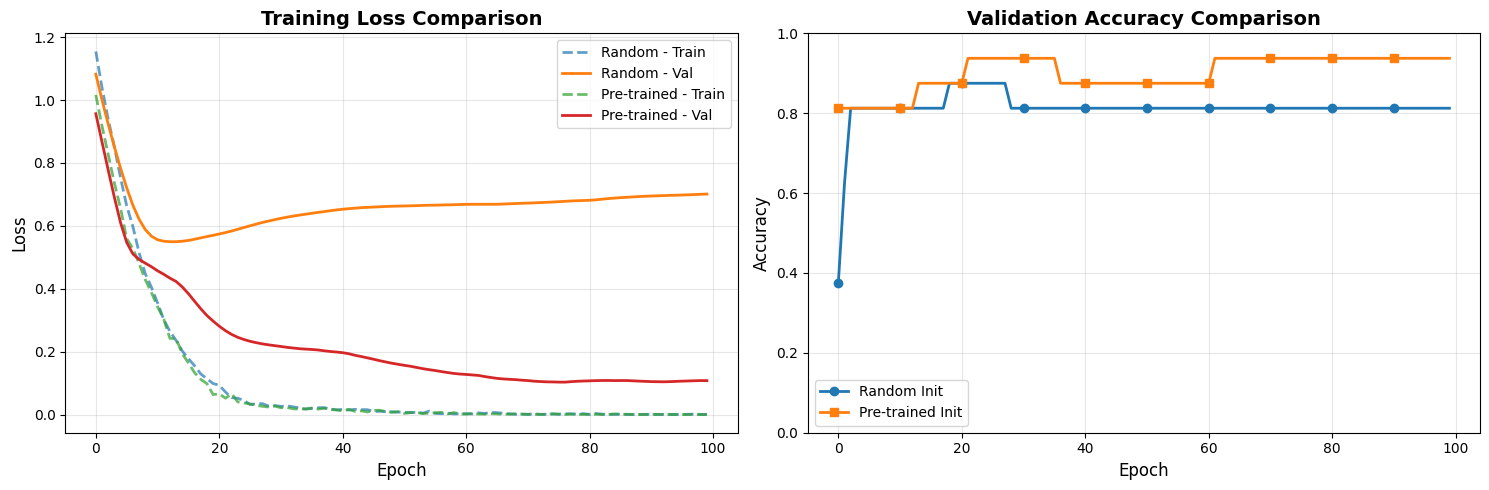

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss comparison
axes[0].plot(train_losses_random, label='Random - Train', linestyle='--', linewidth=2, alpha=0.7)
axes[0].plot(val_losses_random, label='Random - Val', linewidth=2)
axes[0].plot(train_losses_pretrained, label='Pre-trained - Train', linestyle='--', linewidth=2, alpha=0.7)
axes[0].plot(val_losses_pretrained, label='Pre-trained - Val', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy comparison
axes[1].plot(val_accs_random, label='Random Init', linewidth=2, marker='o', markevery=10)
axes[1].plot(val_accs_pretrained, label='Pre-trained Init', linewidth=2, marker='s', markevery=10)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

## 11. 테스트 및 예측 시각화

In [14]:
def predict_sequence(sentence, model, tokenizer, label2idx, idx2label, window_size=5):
    """
    Predict labels for each word in a sentence
    """
    model.eval()
    
    words = sentence.split()
    token_ids = tokenizer.encode(sentence)
    
    # Create windows
    half_window = window_size // 2
    pad_id = tokenizer.word2idx["<PAD>"]
    padded_ids = [pad_id] * half_window + token_ids + [pad_id] * half_window
    
    windows = []
    for i in range(len(token_ids)):
        window = padded_ids[i:i + window_size]
        windows.append(window)
    
    # Predict
    window_tensor = torch.tensor(windows, dtype=torch.long)
    with torch.no_grad():
        logits = model(window_tensor)
        predictions = torch.argmax(logits, dim=1).numpy()
        probabilities = torch.softmax(logits, dim=1).numpy()
    
    return words, predictions, probabilities

# Test sentences
test_sentences = [
    "I visited Paris last summer",
    "New York and Tokyo are amazing cities",
    "The weather is nice today",
    "She lives in Berlin and loves it"
]

print("\n" + "=" * 80)
print("Predictions Comparison: Random vs Pre-trained")
print("=" * 80)

for sent in test_sentences:
    print(f"\nSentence: \"{sent}\"")
    print("-" * 80)
    
    # Predict with both models
    words_rand, preds_rand, probs_rand = predict_sequence(
        sent, model_random, tokenizer, label2idx, idx2label, window_size
    )
    words_pre, preds_pre, probs_pre = predict_sequence(
        sent, model_pretrained, tokenizer, label2idx, idx2label, window_size
    )
    
    # Display
    print(f"{'Word':<15} {'Random Init':<15} {'Pre-trained':<15}")
    print("-" * 80)
    for word, pred_r, pred_p in zip(words_rand, preds_rand, preds_pre):
        label_r = idx2label[pred_r]
        label_p = idx2label[pred_p]
        match = "✓" if label_r == label_p else "✗"
        print(f"{word:<15} {label_r:<15} {label_p:<15} {match}")


Predictions Comparison: Random vs Pre-trained

Sentence: "I visited Paris last summer"
--------------------------------------------------------------------------------
Word            Random Init     Pre-trained    
--------------------------------------------------------------------------------
I               O               O               ✓
visited         O               O               ✓
Paris           B-LOC           B-LOC           ✓
last            O               O               ✓
summer          O               O               ✓

Sentence: "New York and Tokyo are amazing cities"
--------------------------------------------------------------------------------
Word            Random Init     Pre-trained    
--------------------------------------------------------------------------------
New             B-LOC           B-LOC           ✓
York            I-LOC           O               ✗
and             O               O               ✓
Tokyo           B-LOC           B-LOC    

## 12. 요약

### 전체 파이프라인

1. **Tokenization**: 텍스트를 단어로 분리하고 vocabulary 구축
2. **Token ID 변환**: 각 단어를 정수 ID로 매핑
3. **One-hot Encoding**: Token ID를 one-hot 벡터로 변환
4. **Word Embeddings**:
   - **Random**: 랜덤 초기화 (학습 중 업데이트)
   - **Pre-trained**: GloVe embeddings 사용
5. **Sliding Window**: 각 단어를 중심으로 context window 생성
6. **Sequence Labeling**: MLP로 각 위치의 레이블 예측

### 핵심 발견

- **Pre-trained embeddings의 이점**:
  - 의미적으로 유사한 단어들이 embedding space에서 가까이 위치
  - Location 단어들이 자연스럽게 군집을 형성
  - 더 빠른 수렴과 더 높은 정확도

- **Boundary Handling**:
  - Padding tokens로 문장 시작/끝 처리
  - 모든 위치에 대해 동일한 크기의 context window 유지

- **Sequence Labeling**:
  - NER과 유사한 방식으로 각 위치에 레이블 부여
  - BIO tagging scheme 사용
  - Sliding window로 local context 활용

### 확장 가능성

- BiLSTM/Transformer 같은 sequential 모델 사용
- CRF layer 추가로 레이블 간 의존성 모델링
- 더 큰 window size나 contextual embeddings (BERT 등)
- 다른 sequence labeling 태스크 (POS tagging, chunking 등)